# Stellar Interpretation for Meteoritic data and PLotting (for Everyone) - SIMPLE 

In [1]:
import sys

import os
import re
import numpy as np
import matplotlib.pyplot as plt
#import data_dirlib.patches as patch
import time as t
import more_itertools as mit

import h5py
import csv

import datetime
#from datetime import datetime
import ast

# check if the abundance file is there. If it is not available, we load the models and we need more packages.
# or I just remove it and I go ahead with the typical mode
# if check_file is true, there is no need to load all the models again

!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

#if check_data_file == False:
#    sys.path.append('/home/marco/work/NuGridPy')
#    from nugridpy import utils as u
#    from nugridpy import nugridse as mp
from nugridpy import utils as u
from nugridpy import nugridse as mp

#%matplotlib nbagg
%pylab ipympl


# data stored
#data_dir="/data/nugrid/data/chetec-infra_models/"
data_dir="/data/nugrid_data/chetec-infra_models/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# function to load Sieverding+2018
def get_profiles(fname,isotopes=["mg24"],presn=True,decayed=False):
    """ extracts mass fraction profiles from hdf5 data file. 
       keywork argument isotopes=["al26"] specifies which isotopes to return.
       Return value is a dictionary containing a "pre-sn" and post-sn" key and the mass fractions for each isotope as well as the mass coordinates.
    """
# Open HDF5 file
    data_file=h5py.File(fname)
    results=dict()
    #initialize output dicts
    results["pre-sn"]=dict()
    results["post-sn"]=dict()
    
    types=["post-sn"]
    if presn:
        types.append("pre-sn")
    for typ in types:
       data=data_file[typ]
       mr=data["mass_coordinates_sun"]
       results[typ]["mr"]=mr
       # need to decode binary isotope names to get strings
       isos=[ name.decode() for name in data["isotopes"] ]
       #find index jiso for isotope and get zonal mass fractions
       for iso in isotopes:
           jiso=isos.index(iso)
           if decayed and typ=="post-sn":
              results[typ][iso]=data["mass_fractions_decayed"][:,jiso]
           else:
              results[typ][iso]=data["mass_fractions"][:,jiso]
    return(results)


In [3]:
# function to calculate all ratios and slopes from abundance profiles 
def give_ratios(abu, iso_up, iso_down, ref_mu_and_epsilon, ref_slope, method = 'dilution'):
    """ function: returns delta*1000, epsilon*1e4 (or mu*1e6), with and without mass correction, and slopes
    Inputs are: abu: stellar abundances
    iso_abu: isotopes names consistent with stellar abundance arrays
    abu_solar: solar abundances
    iso_solar: isotopes names consistent with the solar abundance array
    iso_up: isotopes I want to calculate the delta for
    iso_down: normalization isotope for delta
    ref_mu_and_epsilon: list of reference isotope used to normalize to get epsilon and mu
    ref_slope: reference isotope used to normalize epsilon*1e4 (ds or dsm) to get the slopes
    method: dummy variable not used here, introduced for give_ratios_gm"""
        
    rho = [abu[e_label.index(iso_up[i])]/\
                  abu[e_label.index(iso_down[i])]/\
                  (s_abu[s_iso_new.index(iso_up[i].replace("*", ""))]/\
                   s_abu[s_iso_new.index(iso_down[i].replace("*", ""))])-1.\
                  for i in range(len(iso_up))]
    ind_ = iso_up.index(ref_mu_and_epsilon[0])
    # ds_maria = ds without applying mass correction (factor)
    ds_maria = np.array(rho) / np.array(rho[ind_])
    # mass correction factor, derived using natural logs of atomic masses
    factor = [np.log(iso_masses[name_iso_masses.index(iso_up[i].replace("*", ""))]/\
                   iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))]) /\
         np.log(iso_masses[name_iso_masses.index(ref_mu_and_epsilon[i].replace("*", ""))]/\
                   iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])\
         for i in range(len(iso_up))] ; factor = np.array(factor)
    # ds is epsilon (/10000) or mu (/1e6), based on kinetic fractionation law - Steele+ 2012
    # Steele+ 2012 only applied for 1 element. Generalize?
    # or, do we need to generalize here, if we plot e,g., mu(Ni) vs mu(Fe)
    ds = [np.array(ds_maria[i]) - factor[i] for i in range(len(iso_up))]
    # and now the slopes... 
    ind_ = iso_up.index(ref_slope)
    # do we need to generalize here, and allow for ds_element1 and ds_element2...
    # corr_factor_mix = ...
    slope = np.array(ds) / np.array(ds[ind_]) # * corr_factor_mix
    # done
    return(rho, slope)


In [4]:
# function to calculate all ratios and slopes from abundance profiles 
# originally developed by "Georgy Makhatadze" <georgy.makhatadze@csfk.org>

def give_ratios_gm(abu, iso_up, iso_down, iso_norm, iso_slope,\
                iso_chem = None, chem_factor = None, solar_ref_for_ratios = 'iniab1.4E-02As09.ppn',\
                abu_convert = True, s_abu_convert = True, approximation_method = 'dilution',\
                precision = 0.01, starting_dilution_factor = 1, dilution_step = 0.1,\
                iteration_method = 'precision', largest_offset = 0.0001):
    """Function: returns isotope ratios in rho-notation and slopes for internally normalised data
    
    Inputs are:
    abu: stellar abundances
    iso_abu: isotopes names consistent with stellar abundance arrays
    abu_solar: solar abundances
    iso_solar: isotopes names consistent with the solar abundance array
    std_ratio: isotope ratios in standards, denominator should have ratio of 1
    std_iso: isotope names for standards
    
    iso_up: numerator isotopes
    iso_down: denominator isotopes
    iso_norm: normalising isotopes
    iso_slope: abscissa isotope used to get the slopes, must be one of iso_up
    iso_chem: isotope used to scale all elements relative to each other, needs to have its chem_factor = 1
    MP: man... this is bad.. what if Si28 is not in e-label?
    chem_factor: chemical fractionation factors,
        each stellar abundance in iso_up is multiplied by number from this array, must be relative to iso_chem
    abu_convert: should we convert abundances from mass to number units
    s_abu_convert: same but for solar
    approximation_method: slope calculation method, can be:
        dilution - artificial dilute sample, similar to Simon+09/ApJ, Makhatadze+23/GCA & maybe more refs
        linear - linearisation from Dauphas+04/EPSL
        better_linear - improved linearisation from Dauphas+14/EPSL & Lugaro+23/EPJA, similar to Steele+12/ApJ
        std_linear - better_linear, but uses isotope ratios of certified standards instead of solar abundances,
            still uses solar abundances for the coefficient between elements
    precision: maximum allowed difference from previous iteration in relative units for the dilution method
    starting_dilution_factor: starting dilution_factor
    dilution_step: how much the factor goes down each iteration
    iteration_method: how dilution_factor is chosen
        largest_offset - by setting the largest allowed mass-independent offset from the solar,
            similar to Ek's notebook for Lugaro+23/EPJA
        precision - by iterating until slopes stop changing
    """
    
    # getting default values for some arguments
    if iso_chem == None: iso_chem = iso_up[0]
    if chem_factor == None: chem_factor = np.array([1.]*len(iso_up))
    
    
    s_abu, s_iso_new = load_solar(file_name_solar = solar_ref_for_ratios)
    #print(solar_ref_for_ratios,s_abu[s_iso_new.index('O-16')])

    
    # my understanding is that you always want to convert.... why do we need this then?
    # conversion for stellar and solar abundances is happening separately now
    if abu_convert: 
        # abundances converted from mass to number unit
        abu_num = [abu[e_label.index(iso_up[i])]/\
                   iso_masses[name_iso_masses.index(iso_up[i].replace("*",""))]\
                   for i in range(len(iso_up))]
        abu_num = np.array(abu_num)
        # abundances for iso_chem are fixed and calculated here now
        abu_num_chem = np.array(abu[e_label.index(iso_chem)]/\
                                iso_masses[name_iso_masses.index(iso_chem.replace("*",""))])
    elif not abu_convert:
        abu_num = [abu[e_label.index(iso_up[i])] for i in range(len(iso_up))]
        abu_num_chem = np.array(abu[e_label.index(iso_chem)])
    else:
        print('invalid abu_convert')
    if s_abu_convert: 
        # solar abundances converted from mass to number unit
        s_abu_num = [s_abu[s_iso_new.index(iso_up[i].replace("*", ""))]/\
                     iso_masses[name_iso_masses.index(iso_up[i].replace("*",""))]\
                     for i in range(len(iso_up))]
        s_abu_num = np.array(s_abu_num)
        s_abu_num_chem = s_abu[s_iso_new.index(iso_chem.replace("*",""))]/\
        iso_masses[name_iso_masses.index(iso_chem.replace("*",""))]
    elif not s_abu_convert:
        s_abu_num = [s_abu[s_iso_new.index(iso_up[i].replace("*", ""))]\
                     for i in range(len(iso_up))]
        s_abu_num = np.array(s_abu_num)
        s_abu_num_chem = s_abu[s_iso_new.index(iso_chem.replace("*",""))]
    else:
        print('invalid s_abu_convert')
    
    # rho for the stellar source, as defined in Dauphas+04
    if approximation_method == 'std_linear':
        # as deviation from the standard
        # here rho is already masked on iso_up
        rho = [abu_num[i]/\
               abu_num[iso_up.index(iso_down[i])]/\
               (std_ratio[std_iso.index(iso_up[i].replace("*", ""))]/\
                std_ratio[std_iso.index(iso_down[i].replace("*", ""))])-1.\
               for i in range(len(iso_up))]
        rho = np.array(rho)    
    else:    
        # as deviation from the solar
        rho = [abu_num[i]/\
               abu_num[iso_up.index(iso_down[i])]/\
               (s_abu_num[i]/\
                s_abu_num[iso_up.index(iso_down[i])])-1.\
               for i in range(len(iso_up))]
        rho = np.array(rho)
    
    # index for slope isotope
    ind_slope = iso_up.index(iso_slope)
    
    if approximation_method != 'dilution':
        # rho for normalising ratios, as defined in Dauphas+04
        if approximation_method == 'std_linear':            
            # as deviation from the standard
            rho_norm = [abu_num[iso_up.index(iso_norm[i])]/\
                        abu_num[iso_up.index(iso_down[i])]/\
                        (std_ratio[std_iso.index(iso_norm[i].replace("*", ""))]/\
                         std_ratio[std_iso.index(iso_down[i].replace("*", ""))])-1.\
                        for i in range(len(iso_norm))]
            rho_norm = np.array(rho_norm)            
        else:        
            # as deviation from the solar
            rho_norm = [abu_num[iso_up.index(iso_norm[i])]/\
                        abu_num[iso_up.index(iso_down[i])]/\
                        (s_abu_num[iso_up.index(iso_norm[i])]/\
                         s_abu_num[iso_up.index(iso_down[i])])-1.\
                        for i in range(len(iso_norm))]
            rho_norm = np.array(rho_norm)
        
        # the only difference between linear and better_linear is how atomic masses are treated
        if approximation_method == 'linear':            
            # linear
            mass_diff_coef = [(iso_masses[name_iso_masses.index(iso_up[i].replace("*", ""))]-\
                               iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])/\
                              (iso_masses[name_iso_masses.index(iso_norm[i].replace("*", ""))]-\
                               iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])\
                              for i in range(len(iso_up))]            
        else:            
            # logarithmic
            mass_diff_coef = [np.log(iso_masses[name_iso_masses.index(iso_up[i].replace("*", ""))]/\
                                     iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])/\
                              np.log(iso_masses[name_iso_masses.index(iso_norm[i].replace("*", ""))]/\
                                     iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])\
                              for i in range(len(iso_up))]            
        mass_diff_coef = np.array(mass_diff_coef)
        
        # coefficient that takes care of different elements plotted together
        diff_ele_coef = [abu_num[iso_up.index(iso_down[i])]/\
                         s_abu_num[iso_up.index(iso_down[i])]\
                         for i in range(len(iso_down))]
        diff_ele_coef = np.array(diff_ele_coef)
        
        # linearised mass-independent rho-values with the applied element coefficient
        rho_mind = [(rho[i] - rho_norm[i]*mass_diff_coef[i])*diff_ele_coef[i]\
                    for i in range(len(iso_up))]
        rho_mind = np.array(rho_mind)
        rho_mind_slope = np.array(rho_mind[ind_slope])
        # those numbers do not have any meaning outside of slope calculation

        # slope on plots where iso_up is ordinate and iso_norm is abscissa
        slope = np.array(rho_mind/rho_mind_slope)
        
    elif approximation_method == 'dilution':        
        # starting dilution_factor
        dilution_factor = starting_dilution_factor
        # counter for the iterations
        counter = 0

        # everything below is in a fake diluted sample
        while True:            
            counter = counter + 1
            print('step', counter, 'dilution_factor =', dilution_factor)
            if counter > 42:
                print('reached', counter, 'iterations, time to stop')
                break
            # you are dead !! dilution_factor constrained by dp
            # from the way it is coded. dilution_factor < 1e-15
            
            # ratios (over iso_chem) in a mixture
            ratio_chem_dilute = [(abu_num[i] * dilution_factor * chem_factor[i] +\
                                  s_abu_num[i] * (1.-dilution_factor))/\
                                 (abu_num_chem * dilution_factor +\
                                  s_abu_num_chem * (1.-dilution_factor))\
                                 for i in range(len(iso_up))]
            ratio_chem_dilute = np.array(ratio_chem_dilute)
            # mixing math fixed
            # NO chem_factor implemented
            
            # isotope ratios in the dilute mixture
            ratio_up = [ratio_chem_dilute[i]/\
                        ratio_chem_dilute[iso_up.index(iso_down[i])]\
                        for i in range(len(iso_up))]
            ratio_up = np.array(ratio_up)
            ratio_norm = [ratio_chem_dilute[iso_up.index(iso_norm[i])]/\
                          ratio_chem_dilute[iso_up.index(iso_down[i])]\
                         for i in range(len(iso_norm))]
            ratio_norm = np.array(ratio_norm)

            # internally normalised mass-independent ratios for the mixtures
            ratio_mind = [ratio_up[i]\
                          *((s_abu_num[iso_up.index(iso_norm[i])]/\
                             s_abu_num[iso_up.index(iso_down[i])])/\
                            ratio_norm[i])**\
                          (np.log(iso_masses[name_iso_masses.index(iso_up[i].replace("*", ""))]/\
                                  iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))])/\
                           np.log(iso_masses[name_iso_masses.index(iso_norm[i].replace("*", ""))]/\
                                  iso_masses[name_iso_masses.index(iso_down[i].replace("*", ""))]))\
                          for i in range(len(iso_up))]
            ratio_mind = np.array(ratio_mind)
            ratio_mind_slope = np.array(ratio_mind[ind_slope])

            # mass-independent rho-values for the mixtures
            rho_mind = [ratio_mind[i]/\
                        (s_abu_num[iso_up.index(iso_up[i])]/\
                         s_abu_num[iso_up.index(iso_down[i])])-1.\
                        for i in range(len(iso_up))]
            rho_mind = np.array(rho_mind)
            rho_mind_slope = np.array(rho_mind[ind_slope])

            # slope on plots where iso_up is ordinate and iso_norm is abscissa
            slope = np.array(rho_mind/rho_mind_slope)
            
            if iteration_method == 'precision':
                
                if counter == 1:
                    slope_prev = np.array(slope)
                    dilution_factor = dilution_factor*dilution_step
                else:
                    # calculates differences between the current iteration and previous
                    slope_diff = np.array(np.arctan(slope) - np.arctan(slope_prev))
                    # checks if difference is within the specified precision
                    precision_check = False
                    for i in range(len(slope_diff)):
                        # yep... this would not work with e.g., AGBs. 1 mass coordinate, the surface. 
                        # So, no len() but float here.
                        for j in range(len(slope_diff[i])):   
                            if slope_diff[i][j] > precision:
                                precision_check = True
                    if precision_check:
                        slope_prev = np.array(slope)
                        dilution_factor = dilution_factor*dilution_step
                        if dilution_factor < 1e-12:
                            print('dilution_factor too small, max slope_diff =', np.max(slope_diff),\
                                  '\ntook', counter, 'iterations, final dilution_factor',\
                                  dilution_factor*dilution_step)
                            break
                    else:
                        print('took', counter, 'iterations, final dilution_factor', dilution_factor)
                        break
                    
            elif iteration_method == 'largest_offset':
                
                if counter == 1:
                    dilution_factor = largest_offset / np.max(np.abs(rho_mind))
                elif np.max(np.abs(rho_mind)) > largest_offset:
                    dilution_factor = dilution_factor * largest_offset / np.max(np.abs(rho_mind))
                else:
                    print('took', counter, 'iterations, final dilution_factor', dilution_factor)
                    break
                
            else:
                print('invalid iteration_method')
                
    else:
        print('invalid approximation_method')
        
    # done
    return(rho, slope)

In [5]:
#def func_el_corr(whatever, abu, ref_up, ref_down, mode=0,file_fractionation=None,what_in_file=None):
#    """Documentation: 
#    # mode = 0: c= (ref_EL1_el2/ref_el1_EL2)_sun/(ref_EL1_el2/ref_el1_EL2)_sun = 1. Same without correction factor;
#    # mode = 1: c= (ref_EL1_el2/ref_el1_EL2)_star*/(ref_EL1_el2/ref_el1_EL2)_sun
#    # mode = 2: c= (ref_EL1_el2/ref_el1_EL2)_file/(ref_EL1_el2/ref_el1_EL2)_sun
#    # function will return whatever * correction factor
#
#    whatever:           whatever is read, delta, epsilon, mu, slope...
#    abu:                abundances from the models used to calculate the whatever loaded
#    ref_up:             ref element 1 in normalization
#    ref_down:           ref element 2 in normalization
#    mode:               see above
#    file_fractionation: file from wich it is read the element fractionation in the sample
#    what_in_file:       specify what correction is needed, given the case of interest """
#    
#    if mode == 0:
#        
#        whatever_corrected = whatever
#    
#    elif mode == 1:
#        
#        c = abu[e_label.index(ref_up)]/abu[e_label.index(ref_down)]/\
#             (s_abu[s_iso_new.index(ref_up.replace("*", ""))]/\
#              s_abu[s_iso_new.index(ref_down.replace("*", ""))])
#        whatever_corrected = whatever * np.array(c)
#    
#    elif mode == 2:
#        
#        # open file and read the fractionation you want from what_in_file
#        f_ = open(file_fractionation, 'r')
#        header = f_.readline()
#        if header.split()[0] != ref_up.rpartition('-')[0]:
#            print('Element 1 in '+file_fractionation+' does not match '+ref_up+'! Stop!')
#        if header.split()[1] != ref_down.rpartition('-')[0]:
#            print('Element 2 in '+file_fractionation+' does not match '+ref_down+'! Stop!')
#        for i in f_.readlines():
#            if i.split()[0] == what_in_file:
#                c = float(i.split()[1])
#                break
#        f_.close() # done with the file
#        c = c/(s_abu[s_iso_new.index(ref_up.replace("*", ""))]/s_abu[s_iso_new.index(ref_down.replace("*", ""))])
#        whatever_corrected = whatever * np.array(c)
#    
#    return(whatever_corrected)
#

In [6]:
def func_species_deck(string_set,abundance,iso_list_spec,iso_list_master):
    """Documentation: 
    # function will return isotope abundance if present in the list, or zero to be added

    string_set:         identifier of the origin set
    abundance:          abundances to be found
    iso_list_spec:      list of isotopes present in the specific model
    iso_list_master:    this should be iso_list, defined by the user """
    dum = []
    for i in iso_list_master:
        try:
            dum.append(abundance[iso_list_spec.index(i)])
        except ValueError:
            dum.append(0.)
            print(string_set,', missing isotope set to zero: ',i)
    
    return(dum)

In [7]:
# load solar data
def load_solar(file_name_solar='iniab1.4E-02As09.ppn'):
    '''
    Function loading the solar abundances that we need to get all the ratios. More than one solar is needed, for 
    different models. :( If not specified a default file is loaded.
    Parameter :
    file_name : name of the solar abundance file (NuGrid format)
    Output (what SIMPLE needs):
    s_iso_new : name of isotopes (this will not change for different solar files) 
    s_abu     : solar abundances
    '''
    f=open(file_name_solar,'r')
    solar_data = f.readlines()
    f.close()
    
    s_iso = []; z_iso = []; abu_s = []
    for i in solar_data:
        s_iso.append(i[3:9].strip())
        z_iso.append(int(i[0:3]))
        abu_s.append(float(i[10:]))
        
    s_iso = np.array(s_iso); abu_s = np.array(abu_s) 
    a_iso = [i[2:].strip() for i in s_iso]; a_iso[0] = '1'; a_iso = [int(i) for i in a_iso]
    s_iso[0] = 'h   1' # correction for H1 special name
    # here below some simple way to build the isotope name with the same structure of the models.
    iso_new_s = [i[:2].strip().capitalize()+'-'+i[2:].strip() for i in s_iso]

    return (abu_s, iso_new_s)    



In [8]:
# check if the abundance file is there. If it is not available, we load the models.
# or I just remove it and I go ahead with the typical mode

#!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

# if check_file is true, there is no need to load all the models again

In [9]:
if check_data_file == False:
    # loading Ritter+18 model
    fol2mod = data_dir+'R18/'
    # load instances of models
    # 15Msun
    pt_15 = mp.se(fol2mod,'M15.0Z2.0e-02.Ma.0020601.out.h5',rewrite=True)
    cyc_15 = pt_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_15  = pt_15.se.get(cyc_15,'temperature')
    mass_15 = pt_15.se.get(cyc_15,'mass')
    # 20Msun
    pt_20 = mp.se(fol2mod,'M20.0Z2.0e-02.Ma.0021101.out.h5',rewrite=True)
    cyc_20 = pt_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_20  = pt_20.se.get(cyc_20,'temperature')
    mass_20 = pt_20.se.get(cyc_20,'mass')
    # 25Msun
    pt_25 = mp.se(fol2mod,'M25.0Z2.0e-02.Ma.0023601.out.h5',rewrite=True)
    cyc_25 = pt_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_25  = pt_25.se.get(cyc_25,'temperature')
    mass_25 = pt_25.se.get(cyc_25,'mass')
    
    # loading AGB models
    # test case, M=3Msun, Z=0.03, Battino et al., getting only the last surf file
    pt_3 = mp.se(data_dir+'agb_surf_m3z2m3/','96101.surf.h5',rewrite=True)


In [10]:
#ccc = pt_3.se.cycles[-1]
#print(ccc, pt_3.se.get(ccc,'iso_massf','C-12'))

In [11]:
if check_data_file == False:
    # loading Pignatari+16 model
    fol2mod = data_dir+'P16/'
    # load instances of models
    # 15Msun
    P16_15 = mp.se(fol2mod,'M15.0',rewrite=True)
    cyc_P16_15 = P16_15.se.cycles[-1]
    #pt_15.se.get('temperature')
    t9_cyc_P16_15  = P16_15.se.get(cyc_P16_15,'temperature')
    mass_P16_15 = P16_15.se.get(cyc_P16_15,'mass')
    # 20Msun
    P16_20 = mp.se(fol2mod,'M20.0',rewrite=True)
    cyc_P16_20 = P16_20.se.cycles[-1]
    #pt_20.se.get('temperature')
    t9_cyc_P16_20  = P16_20.se.get(cyc_P16_20,'temperature')
    mass_P16_20 = P16_20.se.get(cyc_P16_20,'mass')
    # 25Msun
    P16_25 = mp.se(fol2mod,'M25.0',rewrite=True)
    cyc_P16_25 = P16_25.se.cycles[-1]
    #pt_25.se.get('temperature')
    t9_cyc_P16_25  = P16_25.se.get(cyc_P16_25,'temperature')
    mass_P16_25 = P16_25.se.get(cyc_P16_25,'mass')

In [12]:
#!Evelyn new initialization to make Lawson et al. faster
global start_time

z_names = ['Neut', 'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 
           'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 
           'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 
           'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
           'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 
           'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 
           'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U']

def print_time(message):
    print(f"{message} - {(t.time()-start_time):.2f} s")
    

def get_el_from_z(z):
    '''
    Very simple Vfunction that gives the atomic number AS A STRING when given the element symbol.
    Uses predefined a dictionnary.
    Parameter :
    z : string or number
    For the other way, see get_z_from_el
    '''
    z = int(z)
    
    return (z_names[z])    


In [13]:
# function to read Lawson data
def load_lawson22(file_name, num_species):    
    print(file_name)
    #mass_lines = %sx findstr "mass enclosed" {filename}
    # getting mass enclosed and num particle
    mass_lines = !grep 'mass enclosed' {file_name}
    mass = [float(row.split()[3]) for row in mass_lines]
    numpart = [int(row.split()[0][1:]) for row in mass_lines]
    print_time('num and mass')
    number_of_parts = len(numpart) # number of particles (it may change from model to model)
    print('# particles = ',number_of_parts)

    # open and read abundances for all trajectories
    a,x,z,iso = [],[],[],[]
    with open(file_name, "rt") as f:
        i = 0
        while i < number_of_parts:
            f.readline(); f.readline();
            j = 0
            a_i,x_i,z_i,iso_i = [],[],[],[]
            while j < num_species:
                line = f.readline().split()
                a_i.append(int(line[0]))
                z_i.append(int(line[1]))
                x_i.append(float(line[2]))
                iso_i.append(f"{get_el_from_z(line[1])}-{line[0]}")
                j += 1
            a.append(a_i); z.append(z_i); x.append(x_i); iso.append(iso_i)
            i += 1        

    return (mass, numpart, number_of_parts, a, z, x, iso)


In [14]:
if check_data_file == False:
    # Loading Lawson+22 - 1 peformance upgrade
    dir_law = data_dir+'LAW22/'
    models_list = ['M15s_run15f1_216M1.3bgl_mp.txt','M20s_run20f1_300M1.56jl_mp.txt','M25s_run25f1_280M1.83rrl_mp.txt']
    num_species = 5209
    
    start_time = t.time()
    numpart_all = []; massinc_all = []
    anum_all = []; znum_all = []; x_all = []
    iso_name_all = []; num_of_part_all = []
    for i in models_list:
        mass, numpart, number_of_parts, a, z, x, iso = load_lawson22(dir_law+i,num_species)
        massinc_all.append(mass); num_of_part_all.append(number_of_parts); numpart_all.append(numpart) 
        anum_all.append(a); znum_all.append(z); x_all.append(x); iso_name_all.append(iso)
    
    print_time("done with Lawson")

In [15]:
if check_data_file == False:
    # dir where Sieverdin models are located
    dir_sie = data_dir+'SIE18/'
    
    file_sie_all = ["s15_data.hdf5","s20_data.hdf5","s25_data.hdf5"]

In [16]:
if check_data_file == False:
    # Rauscher - 1 peformance upgrade
    dir_rau = data_dir+'R02/'
    
    #models_rau = ['s15a28c.expl_yield']
    models_rau = ['s15a28c.expl_yield','s20a28n.expl_yield','s25a28d.expl_yield']
    
    start_time = t.time()
    
    rau_mass = []; rau_isos = []; rau_x = []
    for i in range(len(models_rau)):
        filename = dir_rau+models_rau[i]
        print(filename)
        f = open(filename,'r')
        head = f.readline(); isos_dum = head.split()[5:] # getting isotopes, not first header names
        #print_time('getting isotopes, not first header names')
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        #print_time('getting the A from isotope name')
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        #print_time('getting the element name from the isotope name')
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        #print_time('more iso name stuff')
        rau_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #print_time('')
        #
        data = f.readlines()[:-2]                        # getting the all data, excepting the last two lines
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[1])/1.989e+33 for ii in data]; rau_mass.append(dum) # converting in Msun too.
        #print_time('converting in Msun too.')
        x_dum = []
        
        
        data = [row.split()[3:] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done")
        rau_x.append(x_dum)


In [17]:
# abundances in mass fraction of all the isotopes in the network. 
# unstable nuclei are allowed to decay only within the first 2.5e4 s
# mmmzvvv.dif_iso_nod  received Jan 2023
# 013a000.dif_iso_nod  020a000.dif_iso_nod
# 015a000.dif_iso_nod  025a000.dif_iso_nod

if check_data_file == False:
    # data from LC18
    dir_lc18 = data_dir+'LC18/'

    models_lc18 = ['015a000.dif_iso_nod','020a000.dif_iso_nod','025a000.dif_iso_nod']
    
    skip_heavy_ = 43 # usedd to skip final ye and spooky abundances (see below)
    
    start_time = t.time()
    
    lc18_mass = []; lc18_isos = []; lc18_x = []
    for i in range(len(models_lc18)):
        filename = dir_lc18+models_lc18[i]
        print(filename)
        f = open(filename,'r')
        # getting isotopes, not first header names, and final ye and spooky abundances (group of isolated isotopes, 
        # probably sorted with artificial reactions handling mass conservation or sink particles approach)
        head = f.readline(); isos_dum = head.split()[4:-skip_heavy_] 
        # correcting names to get H1 (and the crazy P and A)
        isos_dum[0]=isos_dum[0]+'1'; isos_dum[1]=isos_dum[1]+'1'; isos_dum[6]=isos_dum[6]+'1' 
        #print_time('getting isotopes, not first header names')
        dum_a = [re.findall('\d+', ik)[0] for ik in isos_dum] # getting the A from isotope name
        #print_time('getting the A from isotope name')
        dum_el = [re.sub(r'[0-9]+', '', ik) for ik in isos_dum] # getting the element name from the isotope name
        #print_time('getting the element name from the isotope name')
        dum_new_iso = [dum_el[ik].capitalize()+'-'+dum_a[ik] for ik in range(len(isos_dum))]
        #print_time('more iso name stuff')
        lc18_isos.append(dum_new_iso) # isotope name that we can use around, just neutron name is different, but not care
        #print_time('')
        #
        data = f.readlines()[:-1]             # getting the all data, excepting the last fake line (bounch of zeros)
                                              # done reading, just closing the file now
        #
        dum = [float(ii.split()[0]) for ii in data]; lc18_mass.append(dum) # converting in Msun too.
        #print_time('converting in Msun too.')
        x_dum = []
        
        
        data = [row.split()[4:-skip_heavy_] for row in data]
        #
        x_dum = np.transpose(data); x_dum = np.asfarray(x_dum,float)
        print_time("x transpose and done")
        lc18_x.append(x_dum)

#print(len(lc18_isos[0]),len(lc18_x[0]))
#print([lc18_mass[i][-1] for i in [0,1,2]])

In [18]:
# getting the solar for SIMPLE
# this is here just for give_ratios. Once we will use only give_ratios_gm, this line will not be needed
s_abu, s_iso_new = load_solar()

# load isotopic masses from isopy file (csv), based on Wang et al. 2017
with open('isotope_mass_W17.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)
    next(reader); next(reader)
    dum = []
    for row in reader:
        dum.append(row)
iso_dum = dum[0]; iso_masses = np.array([float(i) for i in dum[1]])

# here below some simple way to build the isotope name with the same structure of the models.
name_iso_masses = [re.sub(r'[0-9]+', '', i)+'-'+re.findall(r'\d+', i)[0] for i in iso_dum]

In [19]:
# from development made by Georgy... this is no good for now... here would work only for Fe and Ni
# why do I need this isotope_standard without using solar? Is this attached to a given experiment?
# If this is the case, then this should go in the input deck. 
# load isotope standard data

f = open('isotope_standards.txt', 'r')
standard_data = f.readlines()[1:]
f.close()

std_iso_temp = []
std_ratio = []

for i in standard_data:
    std_iso_temp.append(i[0:6].strip())
    std_ratio.append(float(i[9:]))
    
std_iso_temp = np.array(std_iso_temp)
std_ratio = np.array(std_ratio)

# converted here below to the same SIMPLE shape
std_iso = [i[:2].strip()+'-'+i[2:].strip() for i in std_iso_temp]
print(std_iso)
print(std_ratio)

['Fe-54', 'Fe-56', 'Fe-57', 'Fe-58', 'Ni-58', 'Ni-60', 'Ni-61', 'Ni-62', 'Ni-64']
[0.062669  1.        0.023261  0.0031132 2.596061  1.        0.043469
 0.1386    0.035295 ]


In [20]:
#read in the txt file for the required data
# MP: I think here should also go iso_list and e_label. Any reason why this is not the case?

with open('models.txt', 'r') as f:
    file = f.readlines()

reqmass = int(file[0].strip()) #required solar mass
rmodels = file[1].strip().lower().split(',') #required models
abu_elements=list(file[2].strip().split(','))
abu_name=str(file[3].strip())

# delta, mu, etc for the isotopes you want for element 1
iso_up_plot=list(file[5].strip().split(',')) #stable isotopes
ratio1_elements=list(file[6].strip().split(',')) #required isotopes
iso_down_plot = [file[7].strip()] * len(iso_up_plot)
iso_norm_mu_and_eps = [file[8].strip()] * len(iso_up_plot) # this is the isotope used for the double normalization
iso_norm_slope = file[9].strip() # isotope used for the normalization done on the epsilon or mu to get the slope
ratio1_name=str(file[10].strip())
#if len(file)>13:
#    # delta, mu, etc for the isotopes you want for element 2
#    iso_up_plot2=list(file[12].strip().split(',')) #stable isotopes
#    ratio2_elements=list(file[13].strip().split(',')) #required isotopes
#    iso_down_plot2 = [file[14].strip()] * len(iso_up_plot)
#    iso_norm_mu_and_eps2 = [file[15].strip()] * len(iso_up_plot) # this is the isotope used for the double normalization
#    iso_norm_slope2 = file[16].strip() # isotope used for the normalization done on the epsilon or mu to get the slope
#    ratio2_name=str(file[17].strip())

    


In [21]:
## alright. The previous cells just need to be run once. Once you got instances for all the models,
## you are good to go with the analysis. 
## what of the three models I want for each flavour?
## this is the deck for the models
#
#if check_data_file == False:
#    # ritter+ 18
#    pt_exp = pt_20
#    cyc_exp = cyc_20
#    t9_cyc  = t9_cyc_20
#    mass = mass_20
#    
#    # Pignatari+ 16
#    p16_exp = P16_20
#    p16_cyc = cyc_P16_20
#    p16_t9_cyc  = t9_cyc_P16_20
#    p16_mass = mass_P16_20
#    
#    # lawson+22 # 0=15Msun; 1=20Msun; 2=25Msun
#    ind_ = 1
#    numpart = numpart_all[ind_]; mass_inc = massinc_all[ind_]
#    anum = anum_all[ind_]; znum = znum_all[ind_]; x = x_all[ind_]
#    iso_name = iso_name_all[ind_]; num_of_part = num_of_part_all[ind_]
#    
#    # sieverdin et al # 0=15Msun; 1=20Msun; 2=25Msun
#    ind_ = 1
#    file_sie = file_sie_all[ind_]
#    
#    # Rauscher+02 # 0=15Msun; 1=20Msun; 2=25Msun
#    ind_ = 1
#    rau_mass_1 = rau_mass[ind_]; rau_x_1 = rau_x[ind_]
#    rau_isos_1 = rau_isos[ind_]
#    
#    # Limongi & Chieffi 2018 # 0=15Msun; 1=20Msun; 2=25Msun
#    ind_ = 1
#    lc18_mass_1 = lc18_mass[ind_]; lc18_x_1 = lc18_x[ind_]
#    lc18_isos_1 = lc18_isos[ind_]
#
#

In [22]:
# alright. The previous cells just need to be run once. Once you got instances for all the models,
# you are good to go with the analysis. 
# what of the three models I want for each flavour?
# this is the deck for the models


if reqmass not in [15, 20, 25]:
    print("Error. You can choose only 15, 20, 25 solar mass")
    exit()

if reqmass == 15:
    ind_ = 0
elif reqmass == 20:
    ind_ = 1
elif reqmass == 25:
    ind_ = 2


if check_data_file == False:
    models = {
        15: {
            "pt_exp": pt_15,
            "cyc_exp": cyc_15,
            "t9_cyc": t9_cyc_15,
            "mass": mass_15,
            "p16_exp": P16_15,
            "p16_cyc": cyc_P16_15,
            "p16_t9_cyc": t9_cyc_P16_15,
            "p16_mass": mass_P16_15
        },
        20: {
            "pt_exp": pt_20,
            "cyc_exp": cyc_20,
            "t9_cyc": t9_cyc_20,
            "mass": mass_20,
            "p16_exp": P16_20,
            "p16_cyc": cyc_P16_20,
            "p16_t9_cyc": t9_cyc_P16_20,
            "p16_mass": mass_P16_20
        },
        25: {
            "pt_exp": pt_25,
            "cyc_exp": cyc_25,
            "t9_cyc": t9_cyc_25,
            "mass": mass_25,
            "p16_exp": P16_25,
            "p16_cyc": cyc_P16_25,
            "p16_t9_cyc": t9_cyc_P16_25,
            "p16_mass": mass_P16_25
        }
    }

    # Ritter+18
    pt_exp = models[reqmass]["pt_exp"]
    cyc_exp = models[reqmass]["cyc_exp"]
    t9_cyc = models[reqmass]["t9_cyc"]
    mass = models[reqmass]["mass"]
    
    # Pignatari+16
    p16_exp = models[reqmass]["p16_exp"]
    p16_cyc = models[reqmass]["p16_cyc"]
    p16_t9_cyc = models[reqmass]["p16_t9_cyc"]
    p16_mass = models[reqmass]["p16_mass"]
    
    # lawson+22 # 0=15Msun; 1=20Msun; 2=25Msun
    numpart = numpart_all[ind_]; mass_inc = massinc_all[ind_]
    anum = anum_all[ind_]; znum = znum_all[ind_]; x = x_all[ind_]
    iso_name = iso_name_all[ind_]; num_of_part = num_of_part_all[ind_]
    
    # sieverdin et al # 0=15Msun; 1=20Msun; 2=25Msun
    file_sie = file_sie_all[ind_]
    
    # Rauscher+02 # 0=15Msun; 1=20Msun; 2=25Msun
    rau_mass_1 = rau_mass[ind_]; rau_x_1 = rau_x[ind_]
    rau_isos_1 = rau_isos[ind_]
    
    # Limongi & Chieffi 2018 # 0=15Msun; 1=20Msun; 2=25Msun
    lc18_mass_1 = lc18_mass[ind_]; lc18_x_1 = lc18_x[ind_]
    lc18_isos_1 = lc18_isos[ind_]

In [23]:
if check_data_file == False:
    # Battino et al. -test case AGB
    sparsity_surf = 100
    
    pt_agb  = pt_3
    time_ev = pt_3.se.ages[0::sparsity_surf]
    print(len(time_ev))

In [24]:
if check_data_file == False:
    # getting mass and abundances for single isotopes, or single isotopes + radiogenic "by hand", 
    # or elements by adding isotopes
    
    # deck to create arrays for plotting
    # isotope names to get data and label for plots
    #iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],['Si-29'],['Si-30'],['Ca-40'],['Ca-42'],\
    #            ['Ca-43'],['Ca-44'],['Ca-44','Sc-44','Ti-44'],['Ca-46'],['Ca-48']]
    #e_label = ['He-4','C-12','N-14','O-16','Si-28','Si-29','Si-30','Ca-40','Ca-42','Ca-43',\
    #           'Ca-44','Ca-44*','Ca-46','Ca-48']
#    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],['Ni-56'],\
#                ['Ni-58'],\
#                ['Ni-58','Cu-58'],\
#                ['Ni-60'],\
#                ['Ni-60','Cu-60','Zn-60','Co-60','Fe-60'],\
#                ['Ni-61'],\
#                ['Ni-61','Cu-61','Zn-61','Co-61','Fe-61'],\
#                ['Ni-62'],\
#                ['Ni-62','Cu-62','Zn-62','Co-62','Fe-62'],\
#                ['Ni-64'],\
#                ['Ni-64','Cu-64'],\
#                ['Fe-54','Co-54'],\
#                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
#                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
#                ['Fe-58','Co-58']]#,'Mn-58']] #,'Cr-58']]
#
#    e_label = ['He-4','C-12','O-16','Si-28','Ni-56','Ni-58','Ni-58*','Ni-60','Ni-60*','Ni-61','Ni-61*','Ni-62','Ni-62*',\
#                'Ni-64','Ni-64*',\
#              'Fe-54','Fe-56','Fe-57','Fe-58']
    iso_list = [['He-4'],['C-12'],['O-16'],['Si-28'],['Ni-56'],\
                ['Ti-46'],\
                ['Ti-46','Sc-46'],\
                ['Ti-47'],\
                ['Ti-47','V-47','Sc-47','Ca-47','K-47'],\
                ['Ti-48'],\
                ['Ti-48','V-48','Cr-48','Sc-48'],\
                ['Ti-49'],\
                ['Ti-49','V-49','Cr-49','Sc-49','Ca-49','K-49'],\
                ['Ti-50'],\
                ['Ti-50','Sc-50','Ca-50'],\
                ['Ni-58'],\
                ['Ni-58','Cu-58'],\
                ['Ni-60'],\
                ['Ni-60','Cu-60','Zn-60','Co-60','Fe-60'],\
                ['Ni-61'],\
                ['Ni-61','Cu-61','Zn-61','Co-61','Fe-61'],\
                ['Ni-62'],\
                ['Ni-62','Cu-62','Zn-62','Co-62','Fe-62'],\
                ['Ni-64'],\
                ['Ni-64','Cu-64'],\
                ['Fe-54','Co-54'],\
                ['Fe-56','Ni-56','Co-56','Mn-56','Cr-56'],\
                ['Fe-57','Ni-57','Co-57','Mn-57','Cr-57'],\
                ['Fe-58','Co-58','Mn-58','Cr-58']]

    e_label = ['He-4','C-12','O-16','Si-28','Ni-56',\
               'Ti-46','Ti-46*','Ti-47','Ti-47*','Ti-48','Ti-48*','Ti-49','Ti-49*','Ti-50','Ti-50*',\
               'Ni-58','Ni-58*','Ni-60','Ni-60*','Ni-61','Ni-61*','Ni-62','Ni-62*','Ni-64','Ni-64*',\
                'Fe-54*','Fe-56*','Fe-57*','Fe-58*']

    
#    e_label = ['He-4','C-12','O-16','Si-28','Ni-58','Ni-60','Ni-60*','Ni-61','Ni-62','Ni-64','Ni-64*',\
#              'Fe-54','Fe-56','Fe-57','Fe-58']
    
    
    
    # ritter+18
    cyc_ = cyc_exp 
    mass = pt_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(pt_exp.se.get(cyc_,'iso_massf')); dum_iso = pt_exp.se.isotopes
    
    e_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('rit18',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        e_abund.append(iso_abund)
        
    e_abund = np.array(e_abund)
    
    # pignatari+16
    cyc_ = p16_cyc 
    p16_mass = p16_exp.se.get(cyc_,'mass')
    
    # not loading the full arrays all the time, just once, and transposing around
    dum_ab = np.transpose(p16_exp.se.get(cyc_,'iso_massf')); dum_iso = p16_exp.se.isotopes
    
    p16_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_exp.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('p16',dum_ab,dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        p16_abund.append(iso_abund)
        
    p16_abund = np.array(p16_abund)
    
    
    # Lawson+22
    y = []
    for j in iso_list:
        tmp = []
        for jj in j:
            dum = [x[i][iso_name[i].index(jj)] for i in range(num_of_part)]
            tmp.append(dum)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        y.append(iso_abund)
    
    y = np.array(y)
        
    # Sieverdin+
    flat = [x for sublist in iso_list for x in sublist]
    iso_list_sie = [s.replace("-", "").lower() for s in flat]
    #print(iso_list_sie)
    results=get_profiles(dir_sie+file_sie,isotopes=iso_list_sie,decayed=False)    
    
    sie_abund = []
    for i in iso_list:
        iso_abund = 0.; tmp = [results["post-sn"][iso.replace("-", "").lower()] for iso in i]
        iso_abund = [np.sum(tmp,axis = 0)][0]
        sie_abund.append(iso_abund)
    
    sie_abund = np.array(sie_abund)
        
        
    mass_sie = results["post-sn"]["mr"] # mass
    
    
    # Rauscher+2002
    rau_y = []
    for j in iso_list:
        #tmp = [rau_x_1[rau_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('rau02',rau_x_1,rau_isos_1,j) 
        #print(tmp)
        rau_iso_abund = [np.sum(tmp,axis = 0)][0]
        rau_y.append(rau_iso_abund)
    
    rau_y = np.array(rau_y)
        
    # LC+2018
    lc18_y = []
    for j in iso_list:
        #tmp = [lc18_x_1[lc18_isos_1.index(jj)] for jj in j]
        tmp = func_species_deck('lc18',lc18_x_1,lc18_isos_1,j)
        #print(tmp)
        lc18_iso_abund = [np.sum(tmp,axis = 0)][0]
        lc18_y.append(lc18_iso_abund)
    
    lc18_y = np.array(lc18_y)

In [25]:
if check_data_file == False:
    # AGB surf test
    # not loading the full arrays all the time, just once, and transposing around
    #dum_ab = np.transpose(pt_3.se.get('iso_massf')[0::sparsity_surf]); dum_iso = pt_3.se.isotopes
    #dum_ab = [pt_3.se.get(int(dum_cyc),'iso_massf') for dum_cyc in pt_3.se.cycles[0::sparsity_surf]]
    #
    # oh no... issue in data written in surf files, some as arrays some as list(array(...)). Talk with Umberto, check
    # mppnp revision (an oldy??) and dealing with allocatable arrays. So, just grabbing the last one, bah... 
    #dum_ab = pt_3.se.get('iso_massf')[-1]
    ccc = pt_3.se.cycles[-1] ; dum_ab = pt_3.se.get(ccc,'iso_massf')
    dum_ab = np.array(dum_ab)
    dum_iso = pt_3.se.isotopes
    
    agb_abund = []
    for i in iso_list:
        #iso_abund = 0.; tmp = [pt_3.se.get(cyc_,'iso_massf',ii) for ii in i]
        iso_abund = 0.; tmp = func_species_deck('bat20',np.transpose(dum_ab),dum_iso,i)
        iso_abund = [np.sum(tmp,axis = 0)][0]
        agb_abund.append(iso_abund)
        
    agb_abund = np.array(agb_abund)


In [26]:
if check_data_file == False:
    # preparation for light mode version: write all abundances in an external file:
    # notice the crazy array of lists to list... this is not needed, just to check to be able to write and read
    # multiple times for testing, writing lists as strings and read arrays from strings in the cell below.
    
    data_pot= open('selected_abundances_data.txt','w')
    
    data_pot.write(datetime.date.today().strftime('%Y-%m-%d %H:%M:%S')+' file with selected species - light mode Marco'+'\n')
    # list of species to check and labels
    data_pot.write(str(iso_list)+' \n') # isotope list
    data_pot.write(str(np.array(list(e_label)).tolist())+' \n')  # list for labels in plots
    # rau02
    data_pot.write(str(list(rau_mass_1))+' \n')  # list of Rau02 mass coordinates
    data_pot.write(str(np.array(list(rau_y)).tolist())+' \n')  # list of Rau02 abundances for given mass coordinates
    # rit18
    data_pot.write(str(np.array(list(mass)).tolist())+' \n')  # list of Rit18 mass coordinates
    data_pot.write(str(np.array(list(e_abund)).tolist())+' \n')  # list of Rit18 abundances for given mass coordinates
    # let's add some pain here... the temperature array to check the masscut in the processed ejecta
    data_pot.write(str(np.array(list(t9_cyc)).tolist())+' \n')
    # pgn16
    data_pot.write(str(np.array(list(p16_mass)).tolist())+' \n')  # list of Pgn16 mass coordinates
    data_pot.write(str(np.array(list(p16_abund)).tolist())+' \n')  # list of Pgn16 abundances for given mass coordinates
    # let's add some pain here... the temperature coordinate to check the processed ejecta
    data_pot.write(str(np.array(list(p16_t9_cyc)).tolist())+' \n')
    # law22
    data_pot.write(str(np.array(list(mass_inc)).tolist())+' \n')  # list of Law22 mass coordinates
    data_pot.write(str(np.array(list(y)).tolist())+' \n')  # list of Law22 abundances for given mass coordinates
    # sie18
    data_pot.write(str(np.array(list(mass_sie)).tolist())+' \n')  # list of Sie18 mass coordinates
    data_pot.write(str(np.array(list(sie_abund)).tolist())+' \n')  # list of Sie18 abundances for given mass coordinates
    # LC18
    data_pot.write(str(np.array(list(lc18_mass_1)).tolist())+' \n')  # list of LC18 mass coordinates
    data_pot.write(str(np.array(list(lc18_y)).tolist())+' \n')  # list of LC18 abundances for given mass coordinates
    # bat20
    data_pot.write(str(np.array(list(agb_abund)).tolist())+' \n')  # list of Bat20 abundances for the surface (final step)
    
    
    
    data_pot.close()
    

In [27]:
# and read now.... 

data_pot = open('selected_abundances_data.txt','r')

data_pot.readline()
data  = data_pot.readlines()

data_pot.close()

# .... and rebuild the data back
# list of species to check and labels
iso_list = ast.literal_eval(data[0])
e_label  = ast.literal_eval(data[1])
# rau02
rau_mass_1 = np.array(ast.literal_eval(data[2])); rau_y = np.array(ast.literal_eval(data[3]))
# rit18
mass = np.array(ast.literal_eval(data[4])); e_abund = np.array(ast.literal_eval(data[5]))
t9_cyc = np.array(ast.literal_eval(data[6]))
# pgn16
p16_mass = np.array(ast.literal_eval(data[7])); p16_abund = np.array(ast.literal_eval(data[8]))
p16_t9_cyc = np.array(ast.literal_eval(data[9]))
# law22
mass_inc = np.array(ast.literal_eval(data[10])); y = np.array(ast.literal_eval(data[11]))
# sie18
mass_sie = np.array(ast.literal_eval(data[12])); sie_abund = np.array(ast.literal_eval(data[13]))
# LC18
lc18_mass_1 = np.array(ast.literal_eval(data[14])); lc18_y = np.array(ast.literal_eval(data[15]))
# Bat20
agb_abund = np.array(ast.literal_eval(data[16]))


In [28]:
# delta, mu, etc for the isotopes you want for element 1
# THIS PART IS PROVIDED BY GABOR FILE NOW.
#iso_up_plot         = ['Ni-58','Ni-60','Ni-60*','Ni-61*','Ni-62','Ni-64','Ni-64*']
#iso_down_plot       = ['Ni-58']*len(iso_up_plot)
## these isotopes below should be included in iso_up_plot. 
## Check if they could be other isotopes, e.g., from other elements?
##iso_norm_mu_and_eps = 'Ni-58' # this is the isotope used for the double normalization
#iso_norm_mu_and_eps = ['Ni-61*']*len(iso_up_plot) # this is the isotope used for the double normalization
#iso_norm_slope      = 'Ni-62' # isotope used for the normalization done on the epsilon or mu to get the slope

# what function to use to calculate ratios
func_ratio_dum = give_ratios_gm #give_ratios # give_ratios_gm
# dilution : to be checked, does not work well
# linear : seems to be close to give_ratios
# better_linear : same result as give_ratios
# std_linear : some differences, but close enough (?)
method_dum = 'dilution' #'dilution' #'std_linear' # 'linear' # 'better_linear'
iteration_dum = 'largest_offset'  # 'largest_offset' 'precision'

# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(e_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
               , approximation_method = method_dum, iteration_method = iteration_dum)
rit_deltapmil = data_dump[0]; rit_slope = data_dump[1]

data_dump = \
func_ratio_dum(p16_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
p16_deltapmil = data_dump[0]; p16_slope = data_dump[1]

data_dump = \
func_ratio_dum(y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
law_deltapmil = data_dump[0]; law_slope = data_dump[1]

data_dump = \
func_ratio_dum(sie_abund, iso_up_plot, iso_down_plot,iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02Lo03_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
sie_deltapmil = data_dump[0]; sie_slope = data_dump[1]

data_dump = \
func_ratio_dum(rau_y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.9E-02AG89_AG89.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
rau_deltapmil = data_dump[0]; rau_slope = data_dump[1]

data_dump = \
func_ratio_dum(lc18_y, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02As09_As09.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
lc18_deltapmil = data_dump[0]; lc18_slope = data_dump[1]

# test AGB -Battino+
# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(agb_abund, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
bat_deltapmil = data_dump[0]; bat_slope = data_dump[1]


#print(isinstance(rit_deltapmil,np.ndarray))
#print(isinstance(rit_deltapmil,list))

### delta, mu, etc for the isotopes you want for element 2
###
#iso_up_plot2        = ['Fe-54','Fe-57','Fe-58']
#iso_down_plot2       = ['Fe-56']*len(iso_up_plot2)
## these isotopes below should be included in iso_up_plot. 
## Check if they could be other isotopes, e.g., from other elements?
#iso_norm_mu_and_eps2 = ['Fe-57']*len(iso_up_plot2) # this is the isotope used for the double normalization
#iso_norm_slope2      = 'Ni-58' # isotope used for the normalization done on the epsilon or mu to get the slope
#
### getting the abundance ratio and everything for the models   
#rit_deltapmil2, rit_slope2 = \
#give_ratios(e_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#p16_deltapmil2, p16_slope2 = \
#give_ratios(p16_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#law_deltapmil2, law_slope2 = \
#give_ratios(y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#sie_deltapmil2, sie_slope2 = \
#give_ratios(sie_abund, iso_up_plot2, iso_down_plot2,iso_norm_mu_and_eps2, iso_norm_slope2)
#rau_deltapmil2, rau_slope2 = \
#give_ratios(rau_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#lc18_deltapmil2, lc18_slope2 = \
#give_ratios(lc18_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2)
#

# getting the abundance ratio and everything for the models
#if len(file)>13:
#    rit_deltapmil2, rit_slope2 = \
#    give_ratios(e_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    p16_deltapmil2, p16_slope2 = \
#    give_ratios(p16_abund, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    law_deltapmil2, law_slope2 = \
#    give_ratios(y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    sie_deltapmil2, sie_slope2 = \
#    give_ratios(sie_abund, iso_up_plot2, iso_down_plot2,iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    rau_deltapmil2, rau_slope2 = \
#    give_ratios(rau_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)
#    lc18_deltapmil2, lc18_slope2 = \
#    give_ratios(lc18_y, iso_up_plot2, iso_down_plot2, iso_norm_mu_and_eps2, iso_norm_slope2\
#              , approximation_method = method_dum)

step 1 dilution_factor = 1
step 2 dilution_factor = 1.0882116050010524e-07
step 3 dilution_factor = 1.2403918419219883e-09
step 4 dilution_factor = 1.2303696134750555e-09
step 5 dilution_factor = 1.230368680154577e-09
step 6 dilution_factor = 1.2303686800604595e-09
took 6 iterations, final dilution_factor 1.2303686800604595e-09
step 1 dilution_factor = 1
step 2 dilution_factor = 2.76724061989961e-08
step 3 dilution_factor = 7.707820730077367e-09
took 3 iterations, final dilution_factor 7.707820730077367e-09
step 1 dilution_factor = 1
step 2 dilution_factor = 9.940765376077007e-07
step 3 dilution_factor = 8.266284310203945e-09
step 4 dilution_factor = 8.24849914451606e-09
step 5 dilution_factor = 8.248498823430628e-09
step 6 dilution_factor = 8.248498823413222e-09
took 6 iterations, final dilution_factor 8.248498823413222e-09
step 1 dilution_factor = 1
step 2 dilution_factor = 1.5537104725755084e-06
step 3 dilution_factor = 9.702041993190053e-08
step 4 dilution_factor = 9.69640191257233

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in true_divide


In [29]:
#print(len(sie_abund),len(sie_abund[0]))
#print(len(e_abund),len(e_abund[0]))
#print(len(p16_abund),len(p16_abund[0]))
#print(len(y),len(y[0]))
#print(len(rau_y),len(rau_y[0]))
#print(len(lc18_y),len(lc18_y[0]))
##
#print(len(agb_abund),agb_abund)
#print(bat_slope)
#print(lc18_slope[1])


In [30]:
#print(len(sie_abund),len(sie_abund[0]))
#print(len(e_abund),len(e_abund[0]))
#print(len(p16_abund),len(p16_abund[0]))
#print(len(y),len(y[0]))
#print(len(rau_y),len(rau_y[0]))
#print(len(lc18_y),len(lc18_y[0]))
##
#print(len(agb_abund),agb_abund)
#print(bat_slope)
#print(lc18_slope[1])


In [31]:
#print(len(sie_abund),len(sie_abund[0]))
#print(len(e_abund),len(e_abund[0]))
#print(len(p16_abund),len(p16_abund[0]))
#print(len(y),len(y[0]))
#print(len(rau_y),len(rau_y[0]))
#print(len(lc18_y),len(lc18_y[0]))
##
#print(len(agb_abund),agb_abund)
#print(bat_slope)
#print(lc18_slope[1])

In [32]:
# when 2 elements are involved...
ref_EL1_el2 = 'Ni-61'
ref_el1_EL2 = 'Fe-56'

# correcting quantities in case slope or mu are compared against different elements
# this should work for whatever correct combination:
# rit* with e_abund; law* with y and sie* with sie_abund
# ...
#rit_dsm_corr = func_el_corr(rit_dsm, e_abund, ref_EL1_el2, ref_el1_EL2, mode=1)
#rit_dsm_corr = func_el_corr(rit_slope2, e_abund, ref_EL1_el2, ref_el1_EL2, mode=2,\
#                            file_fractionation='sandbox_element_correction.txt',what_in_file='O-rich_Isaac')

In [33]:
# test solar vs standard-reference-material
# all of those are ratios, all relatives to Ni60, dimensionless
#srm5861 = 2.596061 / 0.043469 
#srm6061 = 1 / 0.043469
#srm6261 = 0.138600 / 0.043469
#srm6461 = 0.035295 / 0.043469

#s5861 = s_abu[s_iso_new.index('Ni-58')]/s_abu[s_iso_new.index('Ni-61')] * (61./58.)
#s6061 = s_abu[s_iso_new.index('Ni-60')]/s_abu[s_iso_new.index('Ni-61')] * (61./60.)
#s6261 = s_abu[s_iso_new.index('Ni-62')]/s_abu[s_iso_new.index('Ni-61')] * (61./62.)
#s6461 = s_abu[s_iso_new.index('Ni-64')]/s_abu[s_iso_new.index('Ni-61')] * (61./64.)

#print(s5861,srm5861,s5861/srm5861)
#print(s6061,srm6061,s6061/srm6061)
#print(s6261,srm6261,s6261/srm6261)
#print(s6461,srm6461,s6461/srm6461)

#corr_srm = np.array([s5861/srm5861, s6061/srm6061, s6061/srm6061 ,s6261/srm6261, s6461/srm6461 ])

In [34]:
# before the plots, some common definitions to share across plots

# colors and marker symbols
#col = np.r_[[[0.0, 0.0, 0.0, 1.0]], cm.rainbow(np.linspace(0, 1,20))]
col=["black", "blue", "brown","red","darkolivegreen","deepskyblue","darkorange",\
     "darkorchid","darkkhaki","mediumvioletred","limegreen"]*3
lin = 'o'
llin='+'
lllin='s'

# xlabels and ylabels in the plots
xlabel1 = 'Mass coordinate M$_{\odot}$'
xlabel2 = 'Time coordinate'

ylabel1 = 'X'; ylabel2 = 'Solar ratio - 1.'
ylabel3 = '$\epsilon$('+iso_norm_mu_and_eps[0]+')'
#ylabel4 = 'slope('+iso_norm_slope+') over '+ylabel3
ylabel4 = 'slope('+iso_norm_slope+') over '+ylabel3


# for plotting purpose, to add a line where iso_ref1 has the largest abundance.
# it must be included in e_label
iso_ref1 = 'Ni-61'

plot_list=[]
for i in abu_elements:
    plot_list.append(iso_list.index([i]))
    
print('index plot_list: ',plot_list)
    
#definitions for abundance plots    
def plot_a():
    if 'pgn' in rmodels:
        p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
        for i in plot_list:
            label_text = "PGN - " + e_label[i]
            plt.semilogy(p16_mass[p16_ind_tmp:], p16_abund[i][p16_ind_tmp:],\
                         color=col[i], markersize=4, ls='--', label=label_text)
    if 'sie' in rmodels:
        for i in plot_list:
            label_text = "SIE - " + e_label[i]
            plt.semilogy(mass_sie[:], sie_abund[i], color=col[i+1], marker=lllin,\
                         ls='--', markersize=0.8, alpha=0.95, label=label_text)
    if 'rau' in rmodels:
        for i in plot_list:
            label_text = "RAU - " + e_label[i]
            plt.semilogy(rau_mass_1, rau_y[i], color=col[i+2], marker=lin,\
                         ls=':', markersize=0.5, alpha=1, label=label_text)
    if 'lc' in rmodels:
        for i in plot_list:
            label_text = "LC - " + e_label[i]
            plt.semilogy(lc18_mass_1, lc18_y[i], color=col[i+3], marker=lllin,\
                         ls='-', markersize=0.8, alpha=0.95, label=label_text)
    if 'law' in rmodels:
        for i in plot_list:
            label_text = "LAW - " + e_label[i]
            plt.semilogy(mass_inc, y[i], color=col[i+4], marker=lin,\
                         ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rit' in rmodels:
        for i in plot_list: # MP: WHY FOR THIS ONE E_ABUND[I+5]?
            label_text = "RIT - " + e_label[i]
            plt.semilogy(mass[ind_tmp:], e_abund[i+5][ind_tmp:], color=col[i], marker=llin,\
                         markersize=4, ls='', label=label_text)

isotope_list=[]
for i in ratio1_elements:
    isotope_list.append(iso_up_plot.index(i))

#definitions for ratio plot   
def plot_r():
    if 'pgn' in rmodels:
        p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
        for i in isotope_list:
            label_text = "PGN - " + iso_up_plot[i]
            plt.plot(p16_mass[p16_ind_tmp:], p16_slope[i][p16_ind_tmp:], color=col[i], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'sie' in rmodels:
        for i in isotope_list:
            label_text = "SIE - " + iso_up_plot[i]
            plt.plot(mass_sie[:], sie_slope[i], color=col[i+1], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rau' in rmodels:
        for i in isotope_list:
            label_text = "RAU - " + iso_up_plot[i]
            plt.plot(rau_mass_1, rau_slope[i], color=col[i+2], marker=lllin, ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'lc' in rmodels:
        for i in isotope_list:
            label_text = "LC - " + iso_up_plot[i]
            plt.plot(lc18_mass_1, lc18_slope[i], color=col[i+3], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'law' in rmodels:
        for i in isotope_list:
            label_text = "LAW - " + iso_up_plot[i]
            plt.plot(mass_inc, law_slope[i], color=col[i+4], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)
    if 'rit' in rmodels:
        for i in isotope_list:
            label_text = "RIT - " + iso_up_plot[i]
            plt.plot(mass[ind_tmp:], rit_slope[i][ind_tmp:], color=col[i+5], marker=lllin,\
                     ls='-', markersize=0.8, alpha=0.5, label=label_text)

index plot_list:  [0, 1, 2, 3, 4, 23]


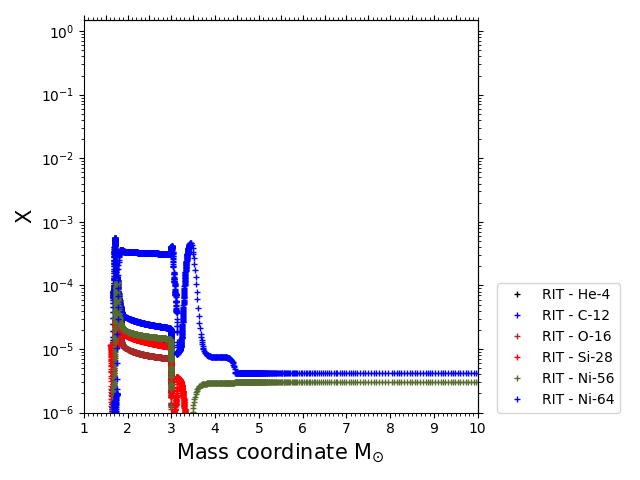

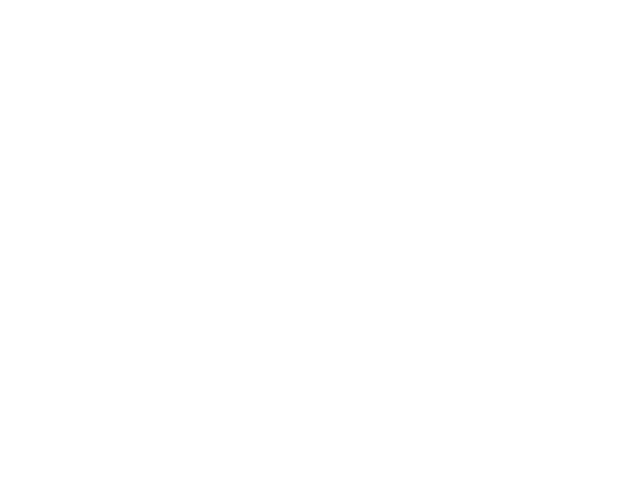

In [35]:
# abundance plot (Gabor 1) MP: why this figure is taking so long to be made?
# what is happening if I select more than one?

plt.clf()
fig, ax = plt.subplots()

ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]

plot_a()

masscut = min(mass[ind_tmp],mass_inc[0])
masscut = min(masscut,min(mass_sie[:]))

ax.set_xlim(1,10)
ax2=ax.secondary_xaxis('top')
ax2.set_xticks(np.arange(1, 10, 0.5))
ax2.set_xticklabels([])
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.set_xlabel(xlabel1,fontsize=15)

ax.set_ylim(1e-6,1.5)
ax3=ax.secondary_yaxis('right')
ax3.set_yticklabels([])
ax.set_ylabel(ylabel1,fontsize=15)

ax.legend(bbox_to_anchor=(1.05, 0), loc="lower left", borderaxespad=0)
plt.tight_layout() 

if abu_name != "":
    plt.savefig(abu_name, bbox_inches='tight', pad_inches=0.1,dpi=300)

plt.show()

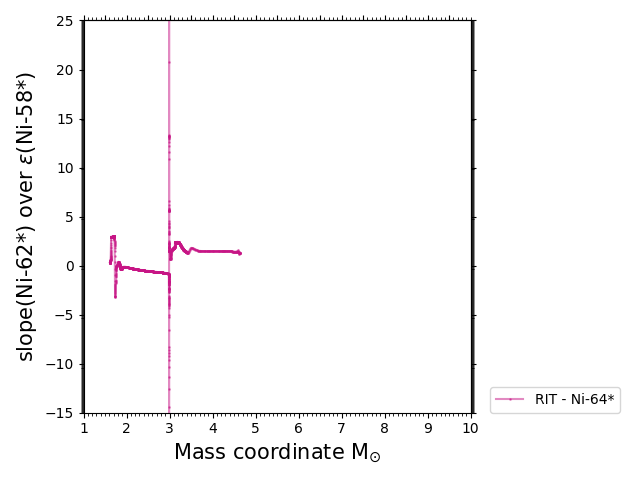

In [36]:
#Ratio plot (Gabor 2) MP: why this figure is taking so long to be made?
plt.clf()
fig, ax = plt.subplots()

ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
  
plot_r()

masscut = min(mass[ind_tmp],mass_inc[0])
masscut = min(masscut,min(mass_sie[:]))

ax.set_xlim(1,10)
ax2=ax.secondary_xaxis('top')
ax2.set_xticks(np.arange(1, 10, 0.5))
ax2.set_xticklabels([])
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.set_xlabel(xlabel1,fontsize=15)

ax.set_ylim(-15,25)
ax3=ax.secondary_yaxis('right')
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax3.set_yticklabels([])
ax.set_ylabel(ylabel4,fontsize=15)
ax3.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
#ax.set_title("Ni-64*/Ni-61*")

ax.legend(bbox_to_anchor=(1.05, 0), loc="lower left", borderaxespad=0)
plt.tight_layout() 

if ratio1_name != "":
    plt.savefig(ratio1_name, bbox_inches='tight', pad_inches=0.1,dpi=300)

plt.show()


In [37]:
## abundance plot; all together
#ifig=2; plt.figure(ifig)
#
#
## to plot abundances (ritter2018)
#
## index to skip what is not ejected
#ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
##
#for i in range(len(iso_list)):
#    plt.semilogy(mass[ind_tmp:],e_abund[i][ind_tmp:],color=col[i],marker=llin,markersize=4,ls='',\
#                 label=e_label[i])
#
#
## to plot abundances (Lawson+2022)
#for i in range(len(iso_list)):
#    plt.semilogy(mass_inc,y[i],color=col[i],marker=lin,ls='-',markersize=0.8,alpha=0.5)
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(mass_sie[:],sie_abund[i],color=col[i],marker=lllin,ls='--',markersize=0.8,alpha=0.5)
#
#
## to plot abundances (Limongi & Chieffi 2018)
#for i in range(len(iso_list)):
#    plt.semilogy(lc18_mass_1,lc18_y[i],color=col[i],marker=lin,ls='-.',markersize=0.5,alpha=1)
#    
#
## to plot abundances (Rauscher+2002)
#for i in range(len(iso_list)):
#    plt.semilogy(rau_mass_1,rau_y[i],color=col[i],marker=lin,ls=':',markersize=0.5,alpha=1)
#
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('messy_test.pdf')
#plt.show()
#

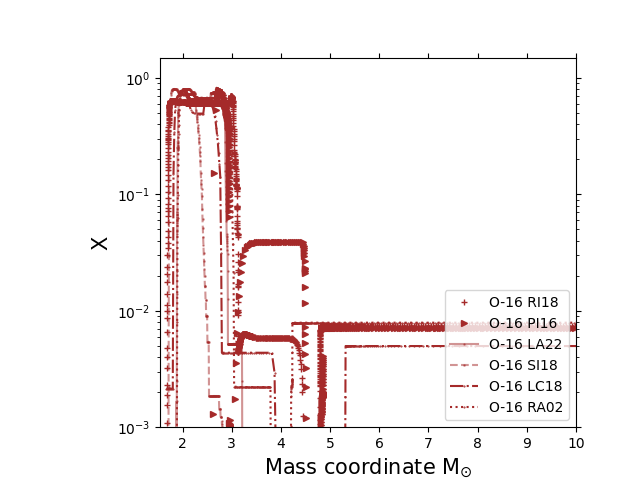

In [38]:
# abundance plot for selected isotopes; all together
ifig=24
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'O-16'
ind_ = e_label.index(iso_selected)

# to plot abundances (ritter2018)

# index to skip what is not ejected
ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
#
plt.semilogy(mass[ind_tmp:],e_abund[ind_][ind_tmp:],color=col[ind_],marker=llin,markersize=4,ls='',\
                 label=e_label[ind_]+' RI18')

# Pignatari+16
# index to skip what is not ejected
p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
#
plt.semilogy(p16_mass[p16_ind_tmp:],p16_abund[ind_][p16_ind_tmp:],color=col[ind_],marker='>',markersize=4,ls='',\
                 label=e_label[ind_]+' PI16')


# to plot abundances (Lawson+2022)
plt.semilogy(mass_inc,y[ind_],color=col[ind_],marker=lin,ls='-',markersize=0.8,alpha=0.5,\
            label=e_label[ind_]+' LA22')

    
# to plot Sieverdin data    
plt.semilogy(mass_sie[:],sie_abund[ind_],color=col[ind_],marker=lllin,ls='--',markersize=0.8,alpha=0.5,
            label=e_label[ind_]+' SI18')


# to plot abundances (Limongi & Chieffi 2018)
plt.semilogy(lc18_mass_1,lc18_y[ind_],color=col[ind_],marker=lin,ls='-.',markersize=0.5,alpha=1,
            label=e_label[ind_]+' LC18')
    

# to plot abundances (Rauscher+2002)
plt.semilogy(rau_mass_1,rau_y[ind_],color=col[ind_],marker=lin,ls=':',markersize=0.5,alpha=1,
            label=e_label[ind_]+' RA02')



plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10); plt.ylim(1e-3,1.5)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('test'+iso_selected+'.pdf')
plt.show()


In [39]:
#print(len(mass[ind_tmp:]))
#print(len(e_abund[0]))
#len(iso_list)

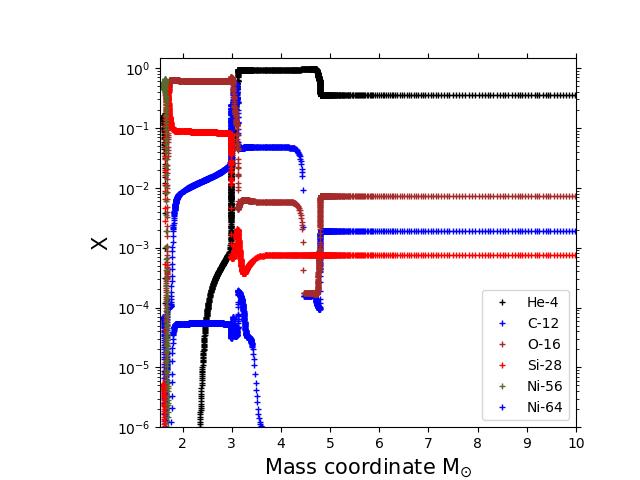

In [40]:
# abundance plot; Ritter
ifig=11
plt.figure(ifig).clear(); plt.figure(ifig)

# to plot abundances (ritter2018)

# index to skip what is not ejected
ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
#
for i in plot_list:
    plt.semilogy(mass[ind_tmp:],e_abund[i][ind_tmp:],color=col[i],marker=llin,\
                 markersize=4,ls='',label=e_label[i])

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('another_test.pdf')
plt.show()

In [41]:
## abundance plot; Lawson
#ifig=12; plt.figure(ifig)
#
#
#
#
## to plot abundances (Lawson+2022)
#for i in range(len(iso_list)):
#    plt.semilogy(mass_inc,y[i],color=col[i],marker=lin,ls='-',markersize=0.8,alpha=0.5,\
#                label=e_label[i])
#
#    
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('test.pdf')
#plt.show()

In [42]:
## abundance plot; Sieverdin
#ifig=13; plt.figure(ifig)
#
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(mass_sie[:],sie_abund[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [43]:
## abundance plot; LC18
#ifig=17; plt.figure(ifig)
#
#
#    
## to plot Sieverdin data    
#for i in range(len(iso_list)):
#    plt.semilogy(lc18_mass_1,lc18_y[i],color=col[i],marker=lllin,ls='-',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#
#    
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [44]:
## abundance plot; P16
#ifig=18; plt.figure(ifig)
#
#
#
## to plot abundances (Pignatari+16)
#
## index to skip what is not ejected
#p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]
##
#for i in range(len(iso_list)):
#    plt.semilogy(p16_mass[p16_ind_tmp:],p16_abund[i][p16_ind_tmp:],color=col[i],marker='>',\
#                 markersize=4,ls='-',label=e_label[i])
#
#
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:])) 
#masscut = min(masscut,p16_mass[p16_ind_tmp])
#plt.xlim(masscut,10); plt.ylim(1e-6,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
##plt.savefig('another_test.pdf')
#plt.show()

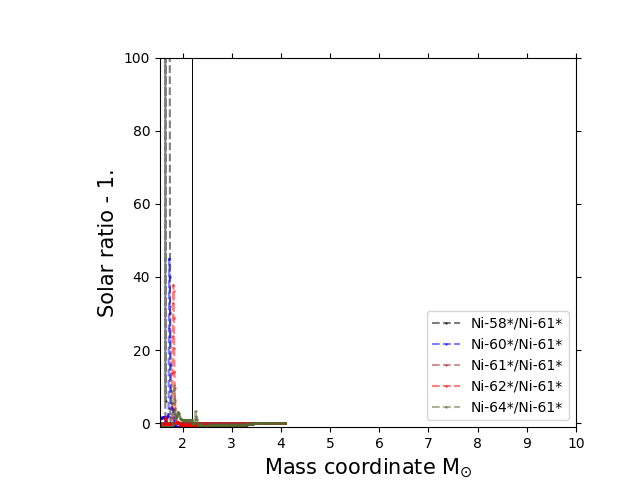

In [45]:
# ratio plot; Sieverdin
ifig=131
plt.figure(ifig).clear(); plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot Sieverdin data    
for i in range(len(iso_up_plot)):
    plt.plot(mass_sie[:],sie_deltapmil[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
    
    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-1.1,100)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel2,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.show()

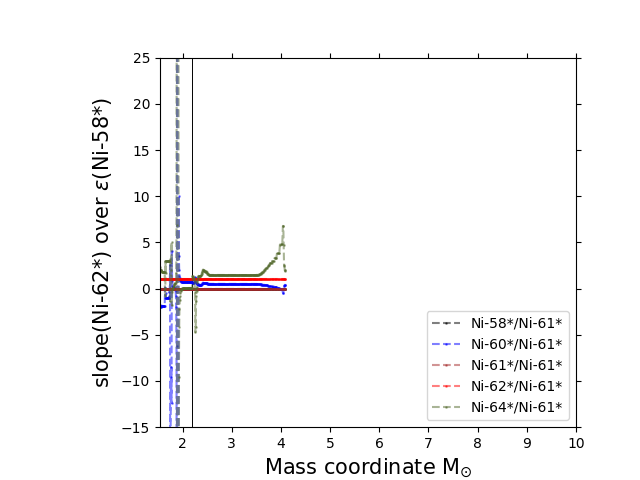

In [46]:
# ratio plot; Sieverdin
ifig=136
plt.figure(ifig).clear(); plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = mass_sie[np.argmax(sie_abund[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot Sieverdin data    
for i in range(len(iso_up_plot)):
    plt.plot(mass_sie[:],sie_slope[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
    
    

plt.legend(loc='lower right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-15,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.show()

In [47]:
## abundance plot; Sieverdin
#ifig=78; plt.figure(ifig)
#
#
#    
## to plot Rauscher data    
#for i in range(len(iso_list)):
#    plt.semilogy(rau_mass_1,rau_y[i],color=col[i],marker=lllin,ls='--',markersize=0.8,\
#                 alpha=0.95,label=e_label[i])
#   
#
#
#plt.legend(loc='lower right')
#masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
#plt.xlim(masscut,10); plt.ylim(1e-8,1.5)
#plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
#plt.gcf().subplots_adjust(left=0.25)    
#
#plt.show()

In [48]:
new_list = ['Ni-58','Ni-61', 'Ni-62', 'Ni-64','Ni-64*']
ind_mass = np.where(np.array(rau_mass_1)>4.2)[0][0]
ind_iso = [e_label.index(i) for i in new_list]
print('mass=',str('%.2e' % rau_mass_1[ind_mass]),'Msun')
print(new_list)
print([rau_y[i][ind_mass] for i in ind_iso])

mass= 4.20e+00 Msun
['Ni-58', 'Ni-61', 'Ni-62', 'Ni-64', 'Ni-64*']
[4.94352e-05, 8.60956e-07, 2.7763e-06, 7.2699e-07, 7.27207106e-07]


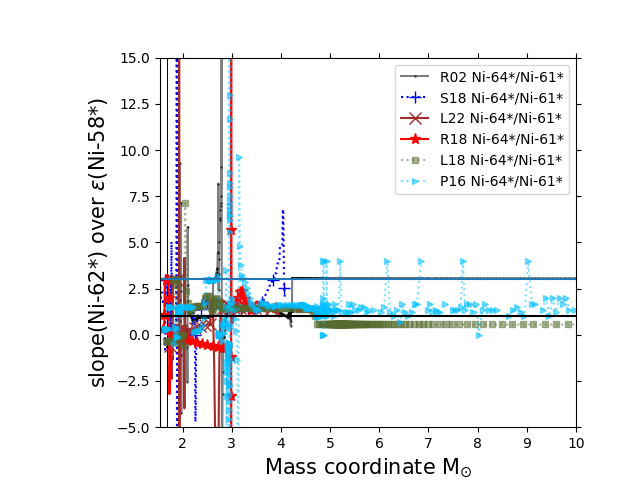

In [58]:
# ratio plot; Rauscher
ifig=87
plt.figure(ifig).clear(); plt.figure(ifig)


# some ref? E.g., where Si28 has the max abundance
ref_1 = rau_mass_1[np.argmax(rau_y[e_label.index(iso_ref1)])]
plt.axvline(x=ref_1,color='k',lw=0.7)
# or where Si29>Si30
#ref_2 = np.where(sie_abund[e_label.index('Si-29')] > sie_abund[e_label.index('Si-30')] )
#[list(group) for group in mit.consecutive_groups(list(ref_2))]
# [...]

# to plot stellar data    
#for i in range(len(iso_up_plot)):
#for i in [1,4]:
#for i in [4]:
#    plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
#                 alpha=0.5,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
#                 alpha=1,markevery=20,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
#    plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
#                 alpha=1,markevery=50,label=iso_up_plot[i]+'/'+iso_down_plot[i])
i = iso_up_plot.index('Ni-64*')
plt.plot(rau_mass_1,rau_slope[i],color=col[0],marker=lllin,ls='-',markersize=0.8,\
                 alpha=0.5,label='R02 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass_sie[:],sie_slope[i],color=col[1],marker='+',ls=':',markersize=8,\
         alpha=1,markevery=20,label='S18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass_inc,law_slope[i],color=col[2],marker='x',ls='-',markersize=8,\
                 alpha=1,markevery=50,label='L22 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(mass[ind_tmp:],rit_slope[i][ind_tmp:],color=col[3],marker='*',ls='-',markersize=8,\
                 alpha=1,markevery=50,label='R18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(lc18_mass_1,lc18_slope[i],color=col[4],marker=lllin,ls=':',markersize=4,\
                 alpha=0.5,label='L18 '+iso_up_plot[i]+'/'+iso_down_plot[i])
plt.plot(p16_mass[p16_ind_tmp:],p16_slope[i][p16_ind_tmp:],color=col[5],marker='>',ls=':',markersize=4,\
                 alpha=0.5,label='P16 '+iso_up_plot[i]+'/'+iso_down_plot[i])

    
plt.axhline(y=3)    
plt.axhline(y=1,ls='-',color='k')    

plt.legend(loc='upper right')
masscut = min(mass[ind_tmp],mass_inc[0]) ; masscut = min(masscut,min(mass_sie[:]))
plt.xlim(masscut,10) ; plt.ylim(-5,15)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('tmp.pdf')

plt.show()

In [50]:
#print('rit',rit_slope[-1])

In [51]:
print(iso_up_plot)
print('law',np.transpose(law_slope)[-1])
print('rit',np.transpose(rit_slope)[-1])
print('rau',np.transpose(rau_slope)[-1])
print('pgn',np.transpose(p16_slope)[-1])
print('lim',np.transpose(lc18_slope)[-1])
print('sie',np.transpose(sie_slope)[-1])


['Ni-58*', 'Ni-60*', 'Ni-61*', 'Ni-62*', 'Ni-64*']
law [-0.5   0.25 -0.    1.    1.  ]
rit [ nan -inf  nan  nan  nan]
rau [0.        2.9313547 0.        1.        3.0539486]
pgn [-0.4  0.6 -0.   1.   1. ]
lim [0.         1.72818063 0.         1.         0.26183239]
sie [ 5.09145786e-07  3.98484477e-01 -0.00000000e+00  1.00000000e+00
  1.95894758e+00]


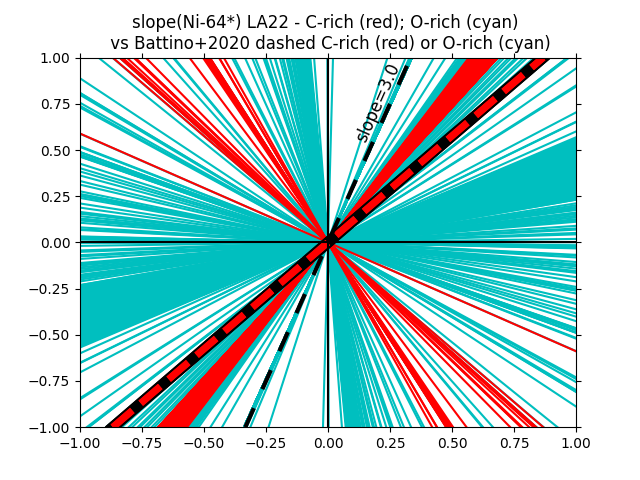

In [52]:
# ratio plot; slopes
ifig=75
plt.figure(ifig).clear(); plt.figure(ifig)

iso_plot = 'Ni-64*'; iso_ref = 'Ni-61'
ind_ = iso_up_plot.index(iso_plot)
indu_ = e_label.index(iso_plot); indd_ = e_label.index(iso_ref) 
indn_ = e_label.index(iso_norm_mu_and_eps[0]) ; inds_ = e_label.index(iso_norm_slope) 

ind_c12 = e_label.index("C-12"); ind_o16 = e_label.index("O-16")

lim_relevance = 5e0

#what_slope = rau_slope; what_abu = rau_y; surf_ind = -1
#what_slope = sie_slope; what_abu = sie_abund; surf_ind = -1 
#what_slope = rit_slope; what_abu = e_abund; surf_ind = -1
what_slope = law_slope; what_abu = y; surf_ind = -1  
#what_slope = lc18_slope; what_abu = lc18_y; surf_ind = -1  
#what_slope = p16_slope; what_abu = p16_abund; surf_ind = -1

[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='c')  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance * what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='r')  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance *  what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

# add comparison - AGB - crazy here since I have only one final snapshot
# note that here below I cannot use surface abundances as indicative anymore....
# well, this is not safe to do either for CCSNe with WR progenitors, Novae, etc. So, all of this will need to
# changed, and use solar as reference or solar scaled.
what_slope = np.transpose(np.concatenate(([bat_slope], [bat_slope]), axis=0))
what_abu = np.transpose(np.concatenate(([agb_abund], [agb_abund]), axis=0)) 
surf_ind = -1        

[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='c',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.axline([0.,0.],[1.,1.*what_slope[ind_][i]], c='r',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

plt.axhline(y=0,color='k'); plt.axvline(x=0,color='k')

# slope from obs?
sl = 3.0
plt.axline((0, 0.0), slope=sl, color="black", linestyle=(0, (5, 5)), lw=3)
plt.text(0.1, 0.55, "slope="+str(sl), rotation=66, fontsize=12)

plt.title('slope('+iso_plot+\
          ') LA22 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')
#plt.title('slope('+iso_plot+\
#          ') SI18 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')

plt.xlim(-1,1); plt.ylim(-1,1)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)


plt.savefig('la22_vs_bat20'+iso_plot+'slope.pdf')

plt.show()
